In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.metrics import confusion_matrix
import shap

In [5]:
# Load the training set data
df = pd.read_csv('Training_set_withtime.csv')
df.head()

,Unnamed: 0,created_at,text_clean,label
0,0,2018-07-23 14:42:01,There are ways for Colorado residents to stret...,1
1,1,2018-07-23 14:20:16,RT Residents flee wildfire raging west of Athens,1
2,2,2018-07-23 14:08:16,Canada B C s Okanagan braces for more wildfires,1
3,3,2018-07-23 14:11:44,Evacuation orders as Ontario s wildfires keep ...,1
4,4,2018-07-23 08:21:09,RT How rewildling can prevent wildfires,1


In [6]:
df.drop(columns='Unnamed: 0',inplace=True)

In [7]:
X = df['text_clean']
y = df['label']

In [8]:
X.shape

(6616,)

In [4]:
# Load the test set
df_test = pd.read_csv('test_data_Feb3rd_2019.csv')
#df_test.drop(columns='Unnamed: 0',inplace =True)
df_test.head()

,date,text_clean,label
0,2019-02-03 09:00:00+00:00,Btw jgh,0
1,2019-02-03 09:00:00+00:00,New Words amp Pictures out today Follow this l...,0
2,2019-02-03 09:00:00+00:00,Weekends are made for adventures We take a fin...,0
3,2019-02-03 09:00:00+00:00,China s surge in global university rankings ha...,0
4,2019-02-03 09:00:00+00:00,4 2 days until LIGHTS OUT in Australia Six wee...,0


In [9]:
X_test = df_test['text_clean']
y_test = df_test['label']
X_test.shape

(173915,)

## Use CountVectorizer

In [11]:
# Put some location name into the stop words to get rid of the effect 
from sklearn.feature_extraction import text 
stop_words_new = text.ENGLISH_STOP_WORDS.union({'greece', 'athens', 'greek'})

In [12]:
# Instiantiate the CountVectorizer, fit and transform X
cvec_new = CountVectorizer(stop_words = stop_words_new, max_features=200)
X_cvec_new = cvec_new.fit_transform(X)

In [13]:
# Transform the test set
X_cvec_test = cvec_new.transform(X_test.values.astype('U'))

In [14]:
# after GridSearch the best parameter for XGBClassifier is 'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 100
xgb_cvec_new =XGBClassifier(learning_rate=0.08, max_depth= 2)
xgb_cvec_new.fit(X_cvec_new, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.08, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [15]:
# Generate the predictions of test set
y_preds_test = xgb_cvec_new.predict(X_cvec_test)

In [16]:
np.count_nonzero(y_preds_test == 1)

6

In [17]:
# Use cross valadation calculate the accuracy of training set
cross_val_score(xgb_cvec_new, X_cvec_new, y, cv=10).mean()

0.996826423390359

In [18]:
print(f'The accuracy of training with more stop words is {round(xgb_cvec_new.score(X_cvec_new, y),3)}')

The accuracy of training with more stop words is 0.997


In [22]:
# The metrics of train set
y_preds = xgb_cvec_new.predict(X_cvec_new)
print(confusion_matrix(y, y_preds))
print('*'*30)
[[tn, fp],[fn, tp] ]= confusion_matrix(y, y_preds)
print(f'Ture Negative {tn}\n Flase Negative {fn}\n True Positive {tp} \n False Positive {fp}')

[[6000    0]
 [  21  595]]
******************************
Ture Negative 6000
 Flase Negative 21
 True Positive 595 
 False Positive 0


In [19]:
# The metrics of test set
y_preds_test = xgb_cvec_new.predict(X_cvec_test)
print(confusion_matrix(y_test, y_preds_test))
print('*'*30)
[[tn, fp],[fn, tp] ]= confusion_matrix(y_test, y_preds_test)
print(f'Ture Negative {tn}\n Flase Negative {fn}\n True Positive {tp} \n False Positive {fp}')

[[173909      0]
 [     0      6]]
******************************
Ture Negative 173909
 Flase Negative 0
 True Positive 6 
 False Positive 0


In [20]:
df_test['preds'] = y_preds_test
df_test.head()

,date,text_clean,label,preds
0,2019-02-03 09:00:00+00:00,Btw jgh,0,0
1,2019-02-03 09:00:00+00:00,New Words amp Pictures out today Follow this l...,0,0
2,2019-02-03 09:00:00+00:00,Weekends are made for adventures We take a fin...,0,0
3,2019-02-03 09:00:00+00:00,China s surge in global university rankings ha...,0,0
4,2019-02-03 09:00:00+00:00,4 2 days until LIGHTS OUT in Australia Six wee...,0,0


In [21]:
df_test['preds'].value_counts()

0    173909
1         6
Name: preds, dtype: int64

In [104]:
df_test.to_csv('test_data_Feb3rd_2019.csv')

In [19]:
df_test[df_test['label']==1]

,date,text_clean,label,preds
16089,2019-02-03 09:46:50+00:00,sadness crept and spread like a wildfire,1,1
61221,2019-02-03 11:45:19+00:00,Tri colored Heron birds nature wildfire photog...,1,1
122334,2019-02-04 01:52:33+00:00,I wonder where you were for the Ca wildfires S...,1,1
122557,2019-02-04 01:52:52+00:00,Don t forget throttled first responders battli...,1,1
125252,2019-02-04 01:56:40+00:00,Are you kidding me wireless throttled data to ...,1,1
126355,2019-02-04 01:58:14+00:00,RT Brown Rust Gold Infinity Scarf Hand Knit Fa...,1,1


In [20]:
# Visualize the top 20 import words
import seaborn as sns
feature_import_list = sorted(zip(map(lambda x: round(x, 4), xgb_cvec_new.feature_importances_), names_new), reverse=True)
feature_import = feature_import_list[:20]
feature_name = []
importance_value = []
for i in range(20):
    importance_value.append(feature_import[i][0])
    feature_name.append(feature_import[i][1])
print(feature_name)
print(importance_value)

['wildfires', 'wildfire', '10', 'update', 'rt', 'know', 'don', 'people', 'new', 'like', 'yes', 'years', 'year', 'ya', 'worst', 'world', 'work', 'won', 'women', 'win']
[0.6761, 0.2994, 0.0065, 0.0048, 0.0032, 0.0029, 0.0021, 0.0019, 0.0017, 0.0014, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


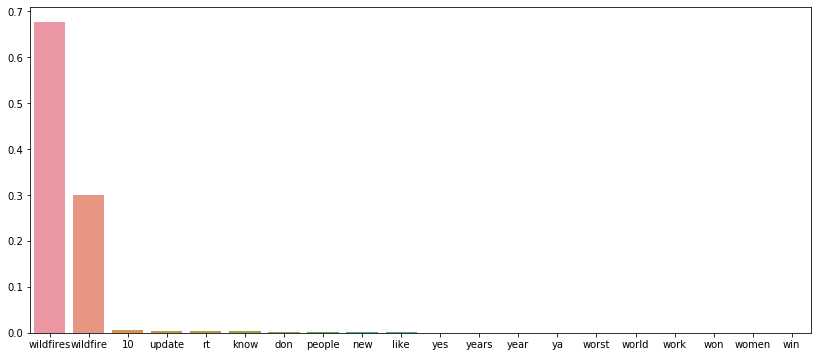

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14,6))
sns.barplot(x=feature_name, y=importance_value);

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


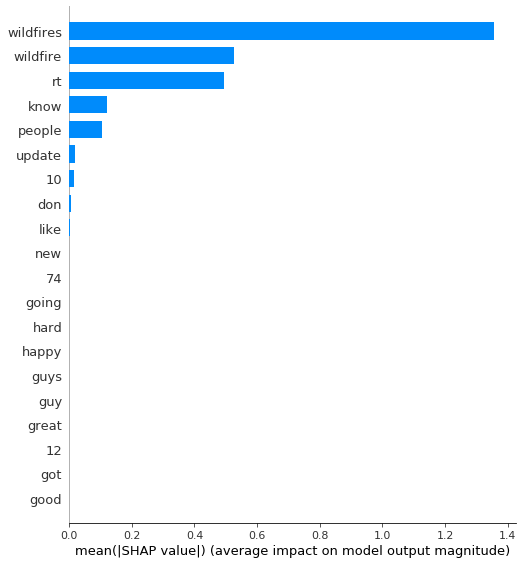

In [22]:
# Use shap to show the words importance 
shap_values = shap.TreeExplainer(xgb_cvec_new).shap_values(X_cvec_new)
shap.summary_plot(shap_values, X_cvec_new, plot_type="bar", feature_names=cvec_new.get_feature_names())

In [23]:
shap_values

array([[-0.00444057,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00449423,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00444057,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00921797,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00921797,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00921797,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

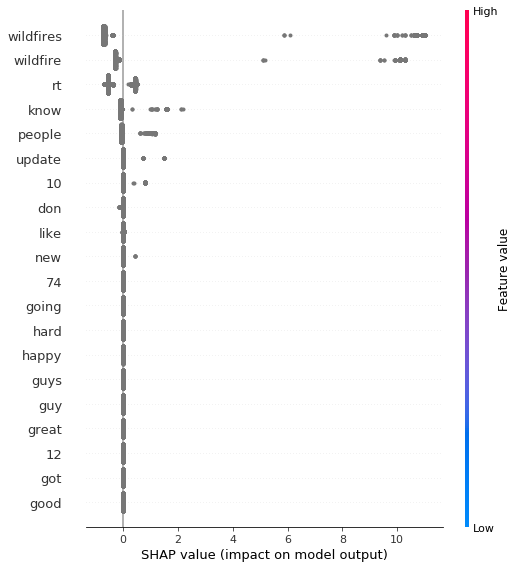

In [25]:
shap.summary_plot(shap_values, X_cvec_new,feature_names=cvec_new.get_feature_names());

In [26]:
# Use GridSearchCV to tuning the best parameters in RandomForestsClassifier
xgb_params = {
    'max_depth':[2,3,4],
    'n_estimators':[100,125,150],
    'learning_rate':[0.08, 0.1, 0.12]
}


gs = GridSearchCV(xgb_cvec_new, 
                 param_grid=xgb_params,
                 cv=5)

gs.fit(X_cvec_new, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.08, 0.1, 0.12],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 125, 150]},
        

In [27]:
print(f'The best score of gridsearch is {gs.best_score_}')
print(f'The best parameter of gridsearch is {gs.best_params_}')

The best score of gridsearch is 0.996826196070909
The best parameter of gridsearch is {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 100}


## Use TfidfVectorizer

In [28]:
tfidf = TfidfVectorizer(stop_words = stop_words_new, max_features=200)
X_tfidf = tfidf.fit_transform(X)
xgb_tfidf = XGBClassifier()
xgb_tfidf.fit(X_tfidf, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
cross_val_score(xgb_tfidf, X_tfidf, y, cv=10).mean()

0.996826423390359

In [30]:
print(f'The accuracy of training is {round(xgb_tfidf.score(X_tfidf, y),3)}')
y_preds1 = xgb_tfidf.predict(X_tfidf)
print(confusion_matrix(y, y_preds1))
print('*'*30)
[[tn, fp],[fn, tp] ]= confusion_matrix(y, y_preds1)
print(f'Ture Negative {tn}\n Flase Negative {fn}\n True Positive {tp} \n False Positive {fp}')

The accuracy of training is 0.997
[[6000    0]
 [  21  595]]
******************************
Ture Negative 6000
 Flase Negative 21
 True Positive 595 
 False Positive 0
